### This is an implementation of a neural network with one hidden layer.

First, a logistic regression model is trained to provide a baseline to compare the neural network model to.

The neural network model will be:

Input --> LINEAR --> TANH --> LINEAR --> SIGMOID

Using sigmoid as output activation because this is a binary classification task.


For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

With the predictions on all the examples, the cost $J$ will be computed as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

Then back propagation is used to get the gradients and update parameters.

Gradient Descent:
$$dz^{[2]} = a^{[2]}-y$$
$$dW^{[2]} = dz^{[2]}a^{[1]T}$$
$$db^{[2]} = dz^{[2]}$$
$$dz^{[1]} = W^{[2]T}dz^{[2]}*g^{[1]'}(z^{[1]})$$
$$a = g^{[1]}(z)$$
$$g^{[1]'}(z) = 1 - a^{2}\tag{for tanh activation}$$
$$dW^{[1]} = dz^{[1]}x^{T}$$
$$db^{[1]} = dz^{[1]}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

# to keep consistent results
np.random.seed(1) 

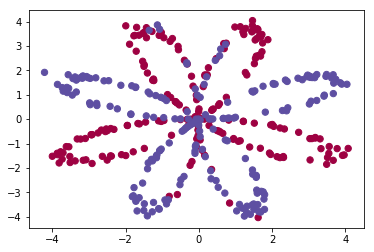

In [2]:
# Load data
X, Y = load_planar_dataset() # helper function to load data

# Visualize data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [3]:
# shape of data
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1] 

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('There are m = {} training examples!'.format(m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
There are m = 400 training examples!


#### Logistic Regression as a baseline

Because the data is not linearly separable, logistic regression won't do very well. Only accuracy of 47%.

/Users/Bing/anaconda3/envs/DeepLearning/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


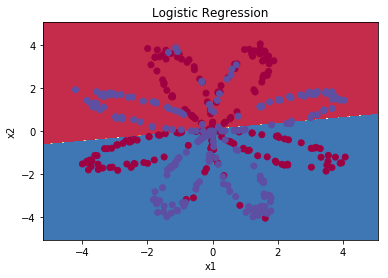

In [4]:
# train logistic regression with sklearn
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

#### Neural Network - 1 hidden layer

In [5]:
def layer_sizes(X, Y, h):
    """
    Generates the sizes of the input, hidden, and output layers
    
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)

    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    
    n_x = X.shape[0] # --> 2   because x1 and x2 inputs and there are 400 examples
    n_h = h         # will use 4 hidden units as the default in the hidden layer
    n_y = Y.shape[0] # --> 1   one row, 400 examples (columns)
    
    return (n_x, n_h, n_y)

def initialize_parameters(n_x, n_h, n_y):
    """
    Initialize parameters with random initialization for weights and biases 
    set at zero.
    
    Arguments:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- dictionary containing parameters:
                W1 -- weight matrix. shape (n_h, n_x)  (# of hidden units, # of input)
                b1 -- biase vector. shape (n_h, 1) (# of hidden units, 1)
                W2 -- weight matrix. shape (n_y, n_h) (output layer size, # of hidden units)
                b2 -- bias vector. shape (n_y, 1)
    """

    np.random.seed(2) # for consistent results
    
    # initialize weights and biases
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    # store parameters
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2
                 }

    return parameters

def forward_prop(X, parameters, g1 = 'tanh'):
    """
    Implements forward prop. 
    
    Argument:
    X -- input data of size (n_x, m)
    parameters -- dictionary containing parameters (output of initialize_parameters)
    
    Returns:
    A2 -- sigmoid output of the second activation
    cache -- a dictionary containing Z1, A1, Z2, and A2    
    """
    
    # retrieve parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # forward prop
    Z1 = np.dot(W1, X)+b1
    if g1 == 'tanh':
        A1 = np.tanh(Z1)
    elif g1 == 'sigmoid':
        A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1)+b2
    A2 = 1/(1+np.exp(-Z2))   # sigmoid
    
    cache = {'Z1':Z1,
             'A1':A1,
             'Z2':Z2,
             'A2':A2}
    
    return A2, cache

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost 
    
    Arguments:
    A2 -- the sigmoid output of the second activation, of shape (1, # of examples)
    Y -- "true" labels vector. shape (1, # of examples)
    parameters -- dictionary containing parameters W1, b1, W2, and b2
    
    Returns:
    cost -- cross-entropy cost     
    """
    
    m = Y.shape[1] # number of examples
    
    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y),np.log(1-A2))
    cost = (-1/m)*np.sum(logprobs)
    
    cost = np.squeeze(cost)  # removes single dimension entries Turns [[x]] into x
    
    return cost

def back_prop(parameters, cache, X, Y):
    """
    Implements back propagation and returns gradients to update parameters.
    
    Arguments:
    parameters -- dictionary containing parameters
    cache -- dictionary containing Zs and activations
    X -- input data of shape (2, # of examples)
    Y -- "true" label vectors of shape (1, # of examples)
    
    Returns:
    grads -- python dictionary contianing gradients with respect to the different parameters
    """
    
    m = X.shape[1]
    
    # retrieve parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # retrieve activations
    A1 = cache['A1']
    A2 = cache['A2']
    
    # back prop
    dZ2 = A2 - Y
    dW2 = (1/m)*np.dot(dZ2, A1.T) # gradient descent over m examples, so 1/m
    db2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True) # over m examples. takes the average of dZ2
    dZ1 = np.dot(W2.T,dZ2)*(1-np.power(A1,2))
    dW1 = (1/m)*np.dot(dZ1, X.T)
    db1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)
    
    grads = {'dW1':dW1,
             'db1':db1,
             'dW2':dW2,
             'db2':db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters with gradient descent update rule
    x = x - learning_rate*dx
    
    Arguments:
    parameters -- dictionary containing parameters
    grads -- dictionary containing gradients
    
    Returns:
    parameters -- dictionary containing UPDATED parameters
    """
    
    # retrieve parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # retrieve gradients
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # update parameters
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2}
    
    return parameters

def model(X, Y, n_h, g1 = 'tanh', num_iterations = 10000, print_cost = False):
    """
    Wraps above functions to implement neural network model
    
    Arguments:
    X -- dataset shape (2, # of examples)
    Y -- labels. shape (1, # of examples)
    n_h -- size of hidden layer
    num_iterations -- number of iterations in gradient descent loop
    print_cost -- if True, prints cost every 1000 iterations
    
    Returns:
    parameters -- parameters learned by the model. These are then used to predict
    """

    np.random.seed(3)

    # get layer sizes
    (n_x,n_h, n_y)= layer_sizes(X,Y, h = n_h)
    
    # initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)

    # retrieve parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # gradient descent loop
    for i in range(0, num_iterations):
        
        # forward prop
        A2, cache = forward_prop(X, parameters, g1 = g1)
        
        # compute cost
        cost = compute_cost(A2, Y, parameters)
        
        # back prop
        grads = back_prop(parameters, cache, X, Y)
        
        # update parameters with gradient descent update rule
        parameters = update_parameters(parameters, grads)
        
        if print_cost and i % 1000 == 0:
            print('Cost after iteration {}: {}'.format(i, cost))
            
    return parameters

def predict(parameters, X):
    """
    Predict using the learned parameters
    
    Arguments:
    parameters -- dictionary containing the updated parameters
    X -- input data of size (n_x, m)
    
    Returns:
    predictions -- vector of predictions from model (red: 0, blue: 1)
    
    """
    A2, cache = forward_prop(X, parameters)
    predictions = (A2 > 0.5) # anything greater than 0.5 will be 1. This statement evaluates True/False which python converts to 1/0

    return predictions
    

Cost after iteration 0: 0.6931247519503794
Cost after iteration 1000: 0.6240636739497795
Cost after iteration 2000: 0.6881756232376043
Cost after iteration 3000: 0.6929491889441718
Cost after iteration 4000: 0.6931448448077692
Cost after iteration 5000: 0.6931468877782843
Cost after iteration 6000: 0.6931471088124023
Cost after iteration 7000: 0.6931471617314736
Cost after iteration 8000: 0.6931471754166415
Cost after iteration 9000: 0.693147179119836


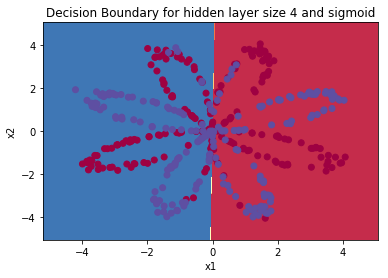

Cost after iteration 0: 0.6930480201239823
Cost after iteration 1000: 0.28808329356901846
Cost after iteration 2000: 0.2543854940732458
Cost after iteration 3000: 0.23386415038952207
Cost after iteration 4000: 0.22679248744854014
Cost after iteration 5000: 0.22264427549299023
Cost after iteration 6000: 0.21973140404281322
Cost after iteration 7000: 0.21750365405131294
Cost after iteration 8000: 0.21950577641358185
Cost after iteration 9000: 0.21862107625156163


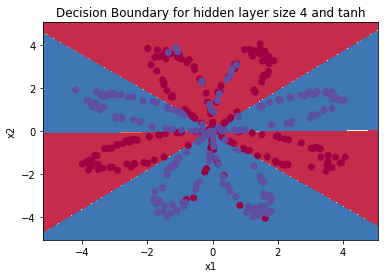

In [6]:
# trying sigmoid activation function for hidden layer
parameters = model(X, Y, n_h = 4,g1='sigmoid', num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size {} and sigmoid".format(str(4)))
plt.show()


# trying tanh activation function for hidden layer
parameters = model(X, Y, n_h = 4,g1= 'tanh', num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size {} and tanh".format(str(4)))
plt.show()


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 50 hidden units: 90.75 %


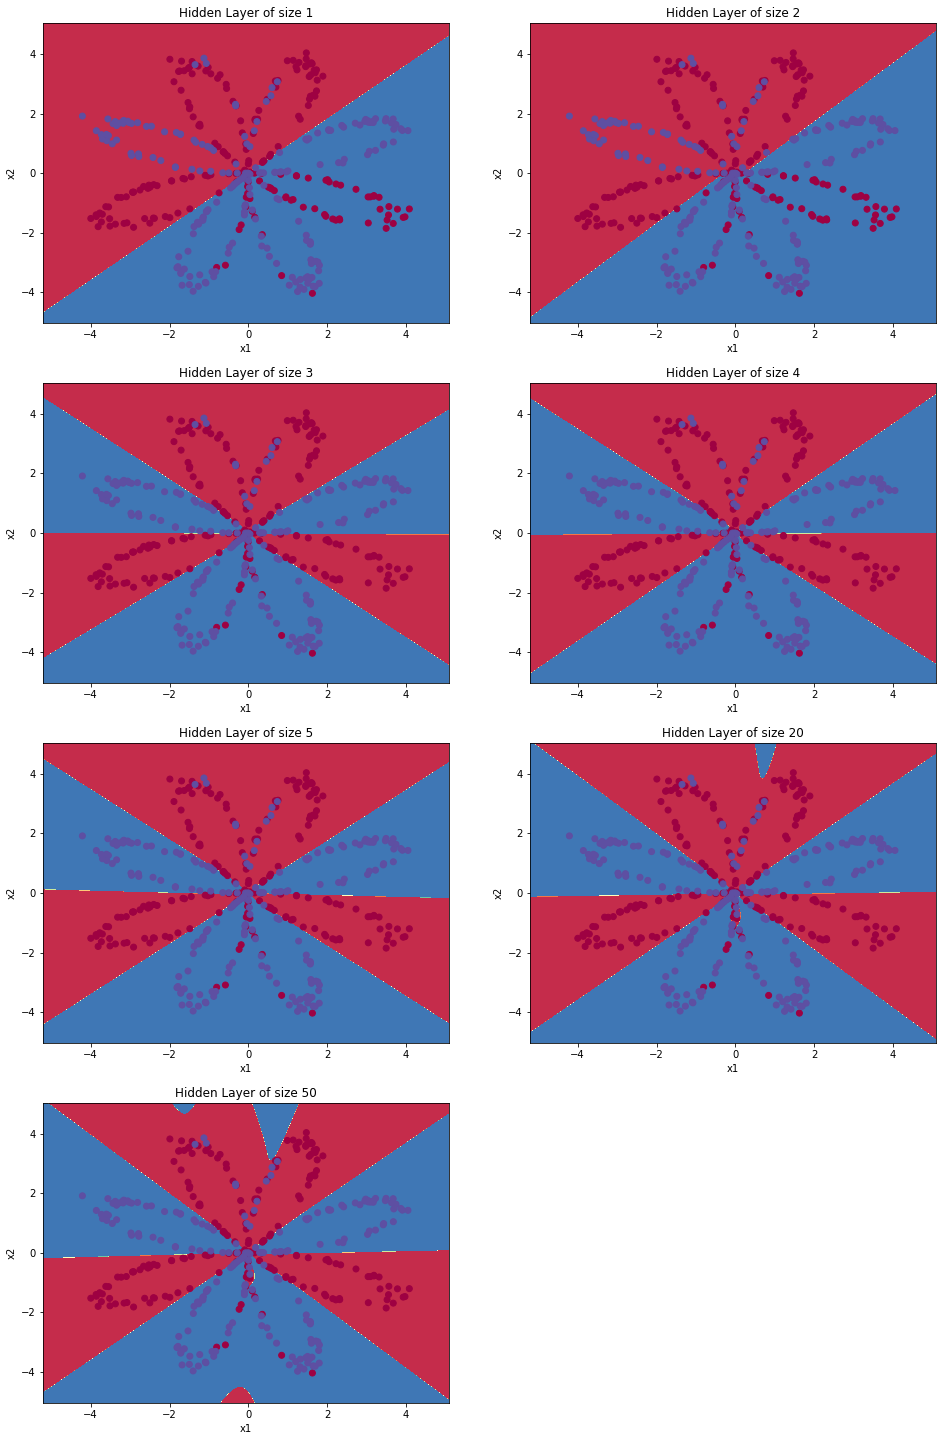

In [7]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))